# Project 3: Web APIs & NLP

### By Alex Lau

## 1. Problem Statement

Automobiles have progressed slowly over the last century. Most cars on the road today are still powered by gasoline, a non-renewable resource that pollutes the air and contributes to global warming. There is one manufacturer that is revolutionizing transportation with electric vehicles: Tesla Motors. We have decided to investigate subreddit titles from a popular American social news website, Reddit, to better understand the public sentiments surrounding Tesla. Our goal is to correctly classify the titles of posts as originating from subreddit 'cars' or 'teslamotors'. We plan to solve this problem using Logistic Regression and Multinomial Naive Bayes Classifier. Our models will be evaluated using Accuracy Scores. As Data Scientists of the 21st century, it is important that we leverage what we learn from this process to drive the population to transition to clean energy sources.

## 2. Executive Summary

2-4 Paragraphs (NOT bullet points)

__BROAD__ overview of workflow.
- What did you start with _(What's your data? Where did you get it?)_
- What did you do with it _(Brief overview of data cleaning and EDA process - don't get too into the weeds describing your cleaning)_
- Process for finding best model

Here's what I found. Here are some of the key takeaways and interesting findings. _(this should flow naturally into your conclusions & recommendations)_

## 3. Table of Contents

1. [Problem Statement](#1.-Problem-Statement)
2. [Executive Summary](#2.-Executive-Summary)
3. [Table of Contents](#3.-Table-of-Contents)
4. [Loading Libraries & Data](#4.-Loading-Libraries-&-Data)
5. [Web Scraping](#5.-Web-Scraping)
6. [Exploratory Data Analysis (EDA)](#6.-Preliminary-EDA)
7. [Data Cleaning](#7.-Data-Cleaning)
8. [Model Preperation (Preprocessing)](#9.-Model-Preparation-(Preprocessing))
9. [Modeling](#10-Modeling)
    <br>9.1 [Baseline Model](#9.1-Baseline-Model)
    <br>9.2 [Logistic Regression](#9.2-Logistic-Regression)
    <br>9.3 [Gaussian Naive Bayes](#9.3-Gaussian-Naive-Bayes)
10. [Model_Selection](#11.-Model-Selection)
11. [Model Evaluation](#12.-Model-Evaluation)
12. [Conclusions and Evaluation](#13.-Conclusions-and-Evaluation)

## 4. Loading Libraries & Data

In [2]:
# Import libaries
import pandas as pd
import numpy as np
import requests
import datetime as dt
import time
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from nltk import word_tokenize, ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize          

## 5. Web Scraping

In [3]:
# we're asking pushshift to engage with redit website
def query_pushshift(subreddit, kind='submission', skip=30, times=5, 
                    subfield = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 
                                'score', 'is_self'],
                    comfields = ['body', 'score', 'created_utc']):
    stem = "https://api.pushshift.io/reddit/search/{}/?subreddit={}&size=500".format(kind, subreddit)
    
    mylist = []
    
    for x in range(1, times + 1):
        
        URL = "{}&after={}d".format(stem, skip * x)
        print(URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        mylist.append(df)
        time.sleep(2)
        
    full = pd.concat(mylist, sort=False)
    
    if kind == "submission":
        
        full = full[subfield]
        
        full = full.drop_duplicates()
        
        full = full.loc[full['is_self'] == True]
        
    def get_date(created):
        return dt.date.fromtimestamp(created)
    
    _timestamp = full["created_utc"].apply(get_date)
    
    full['timestamp'] = _timestamp
    print(full.shape)
    
    return full 

In [4]:
sub_1_query = query_pushshift('teslamotors')

https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=30d
https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=60d
https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=90d
https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=120d
https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=150d
(1347, 9)


In [5]:
sub_2_query = query_pushshift('cars')

https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=30d
https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=60d
https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=90d
https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=120d
https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=150d
(1648, 9)


In [6]:
combined_sub_queries = pd.concat([sub_1_query, sub_2_query])

## 6. Exploratory Data Analysis

In [7]:
combined_sub_queries.shape

(2995, 9)

In [8]:
combined_sub_queries.dtypes

title           object
selftext        object
subreddit       object
created_utc      int64
author          object
num_comments     int64
score            int64
is_self           bool
timestamp       object
dtype: object

In [9]:
combined_sub_queries.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
1,First long road trip with our Model 3! Some th...,We got our LR RWD Model 3 back in April 2018. ...,teslamotors,1577768864,LanFeusT23,132,1,True,2019-12-31
3,When do you file the 8936 EV tax credit form?,I picked up my Model 3 back in August this yea...,teslamotors,1577771949,isoplayer,0,1,True,2019-12-31
5,Model S Fender Flares,Hello! I hope this exceeds the Low Quality po...,teslamotors,1577772342,IAmDarthMole,2,1,True,2019-12-31
8,"Mar 4, 2019 Article - Tesla Shares Will Breach...","I saved this for posterity when it was posted,...",teslamotors,1577774293,rkeith5,46,1,True,2019-12-31
10,Can you buy Tesla Acceleration Update with Pay...,This is a pretty straightforward question. I g...,teslamotors,1577775193,longlivegreenearth,1,1,True,2019-12-31


In [10]:
combined_sub_queries.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
490,How good is a GTR R34 2002 as a daily driver?,[removed],cars,1567588357,Oeirs,3,1,True,2019-09-04
491,I don't want a 'normie' car.,"I know this sounds pretentious as fuck, but I ...",cars,1567589149,Dyllbyll,38,0,True,2019-09-04
495,Need some help,[removed],cars,1567591430,tbrits88,2,1,True,2019-09-04
497,Finally got my first dream car a 2013 Infiniti...,So I finally went out and got one of my first ...,cars,1567592222,NateT1015,0,1,True,2019-09-04
499,Reconditioned &amp; used Range Rover Evoque En...,[removed],cars,1567593458,DavidRonan,0,1,True,2019-09-04


In [11]:
combined_sub_queries.describe()

,created_utc,num_comments,score
count,2.995000e+03,2995.000000,2995.000000
mean,1.572771e+09,21.678798,13.059098
std,3.674337e+06,84.732975,137.760808
min,1.567397e+09,0.000000,0.000000
25%,1.570070e+09,0.000000,1.000000
50%,1.572735e+09,2.000000,1.000000
75%,1.575411e+09,15.000000,1.000000
max,1.578102e+09,2962.000000,5222.000000


In [12]:
combined_sub_queries.isnull().sum()

title            0
selftext        19
subreddit        0
created_utc      0
author           0
num_comments     0
score            0
is_self          0
timestamp        0
dtype: int64

In [13]:
combined_sub_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2995 entries, 1 to 499
Data columns (total 9 columns):
title           2995 non-null object
selftext        2976 non-null object
subreddit       2995 non-null object
created_utc     2995 non-null int64
author          2995 non-null object
num_comments    2995 non-null int64
score           2995 non-null int64
is_self         2995 non-null bool
timestamp       2995 non-null object
dtypes: bool(1), int64(3), object(5)
memory usage: 213.5+ KB


In [14]:
combined_sub_queries['score'].value_counts()

1       2177
0        213
2         77
3         44
5         40
        ... 
57         1
59         1
61         1
65         1
4068       1
Name: score, Length: 130, dtype: int64

In [15]:
combined_sub_queries[combined_sub_queries['selftext']=='[removed]']

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
11,HW3 Upgrades,[removed],teslamotors,1577775607,JohnAsHimself,0,1,True,2019-12-31
21,Garage door remote delete,[removed],teslamotors,1577794040,Satyrr,0,1,True,2019-12-31
30,Tesla s screen responsiveness,[removed],teslamotors,1577801800,nutteez,0,1,True,2019-12-31
31,I lost a Tesla bet so now I am paying up.,[removed],teslamotors,1577803979,Brad_Wesley,28,1,True,2019-12-31
33,Hmm,[removed],teslamotors,1577804855,Mako_sato_ftw,0,1,True,2019-12-31
...,...,...,...,...,...,...,...,...,...
484,How good is a Skyline GTR R34 2002 as a daily ...,[removed],cars,1567586407,Oeirs,1,1,True,2019-09-04
485,[Serious] With infotainment being such an inte...,[removed],cars,1567586518,NorCalAthlete,2,0,True,2019-09-04
490,How good is a GTR R34 2002 as a daily driver?,[removed],cars,1567588357,Oeirs,3,1,True,2019-09-04
495,Need some help,[removed],cars,1567591430,tbrits88,2,1,True,2019-09-04


In [16]:
# consider using features where comments > 20?
combined_sub_queries.groupby('subreddit').mean()

,created_utc,num_comments,score,is_self
subreddit,,,,
cars,1.572672e+09,21.541262,11.408981,True
teslamotors,1.572892e+09,21.847068,15.077951,True


In [17]:
# Split data up into X and y.
X = combined_sub_queries['title']
y = combined_sub_queries['subreddit'].map(lambda x: 1 if x == 'teslamotors' else 0)

In [18]:
# Split dataa into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Instantiate CountVectorizer.
cv = CountVectorizer()

# Fit CountVectorizer to training data.
cv.fit(X_train)

# Transform training and testing data based on the fit CountVectorizer.
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [19]:
# Create a DataFrame with our words.
words = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [20]:
words.sum()

000             13
000rpm           1
01               4
02               4
03               7
                ..
zero             1
zonda            1
zones            1
zx4              1
معلومه_بتهمك     1
Length: 4192, dtype: int64

In [21]:
# Let's look at the most frequently used words.
words.sum().sort_values(ascending=False).head(20)

the      595
to       480
car      407
for      312
tesla    281
in       281
is       266
and      262
on       244
of       229
model    221
my       197
it       186
what     181
how      157
with     151
you      147
or       114
are      110
cars     104
dtype: int64

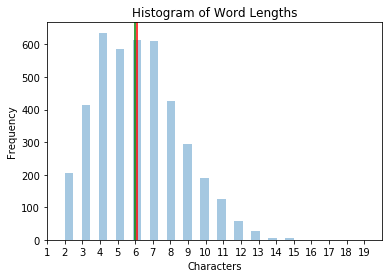

In [22]:
# Plot the lengths of the words.
lengths_of_words = [len(each) for each in words.columns]
fig, ax = plt.subplots()
sns.distplot(lengths_of_words, ax=ax, kde = False)
plt.title('Histogram of Word Lengths')
plt.axvline(np.mean(lengths_of_words), 0,350, color = 'red')
plt.axvline(np.median(lengths_of_words), 0,350, color = 'green')
plt.ylabel('Frequency')
plt.xlabel('Characters')
ax.set_xlim(1,20)
ax.set_xticks(range(1,20))
plt.show();

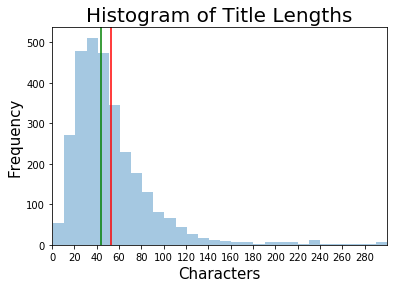

In [23]:
# Plot the lengths of the posts.
lengths_of_posts = [len(each) for each in X]
fig, ax = plt.subplots()
sns.distplot(lengths_of_posts, kde = False, bins = 30) #kde = False
plt.title('Histogram of Title Lengths', size = 20)
plt.axvline(np.mean(lengths_of_posts), 0,350, color = 'red')
plt.axvline(np.median(lengths_of_posts), 0,350, color = 'green')
plt.ylabel('Frequency', size = 15)
plt.xlabel('Characters', size = 15)
ax.set_xlim(1,300)
ax.set_xticks(range(0, 300, 20))
plt.show();

In [24]:
np.mean(lengths_of_posts)

53.151919866444075

In [25]:
np.median(lengths_of_posts)

44.0

In [26]:
combined_sub_queries['subreddit'].value_counts()

cars           1648
teslamotors    1347
Name: subreddit, dtype: int64

## 7. Data Cleaning

In [27]:
combined_sub_queries = combined_sub_queries.drop_duplicates()

In [28]:
combined_sub_queries['subreddit'].value_counts()

cars           1648
teslamotors    1347
Name: subreddit, dtype: int64

In [29]:
combined_sub_queries.isnull().sum().sort_values(ascending = False)

selftext        19
timestamp        0
is_self          0
score            0
num_comments     0
author           0
created_utc      0
subreddit        0
title            0
dtype: int64

## 8. Model Preparation (Preprocessing)

In [30]:
X = combined_sub_queries['title']
y = combined_sub_queries['subreddit']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [32]:
lemmatizer = WordNetLemmatizer()

def lemmatizing_tokenizer(str_input):
    tokens = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    stems = [lemmatizer.lemmatize(word) for word in tokens]
    return stems

# following code found on https://scikit-learn.org/stable/modules/feature_extraction.html
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    

class StemTokenizer:
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc)]

## 9 Modeling

### 9.1 Baseline Model

Our baseline is __ (this value changes everytime I run the reddit script)

In [33]:
y.value_counts(normalize = True)

cars           0.55025
teslamotors    0.44975
Name: subreddit, dtype: float64

### 9.2 Logistic Regression

#### Count Vectorizer

In [46]:
# Instantiate pipeline.  
pipe_cv = Pipeline([
    ('cv', CountVectorizer()), 
    ('lr', LogisticRegression())
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'cv__tokenizer': [LemmaTokenizer()], # tried [StemTokenizer(), None] with lower accuracy test scores
    'cv__max_features': [3950, 4000], # fine tuned to this max_features
    'cv__stop_words': ['english'],
    'cv__ngram_range': [(1,8)], # fine tuned to this ngram range
    'lr__solver': ['lbfgs'] # ['liblinear', 'saga'] lower accuracy test scores
}

# GridSearch over pipeline with given grid of parameters.
gs_cv = GridSearchCV(pipe_cv, params_grid, cv=5, scoring = 'accuracy')

# Fit model.
gs_cv.fit(X_train, y_train)

print(f'GridSearch score with CountVectorized features and Logistic Regression on training set is {round(gs_cv.score(X_train, y_train), 4)}.')
print()
print(f'GridSearch score with CountVectorized features and Logistic Regression on testing set is {round(gs_cv.score(X_test, y_test), 4)}.')

C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\env

GridSearch score with CountVectorized features and Logistic Regression on training set is 0.9555.

GridSearch score with CountVectorized features and Logistic Regression on testing set is 0.8652.


In [47]:
gs_cv.best_estimator_

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=3950, min_df=1,
                                 ngram_range=(1, 8), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x000001E2461BE308>,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
          

In [48]:
gs_cv.best_params_

{'cv__max_features': 3950,
 'cv__ngram_range': (1, 8),
 'cv__stop_words': 'english',
 'cv__tokenizer': <__main__.LemmaTokenizer at 0x1e2461be308>,
 'lr__solver': 'lbfgs'}

#### TFIDF

In [43]:
# Define Pipeline - TFIDF
pipe_tfidf = Pipeline(steps = [('tfidfvec', TfidfVectorizer()),     # first tuple is for first step: vectorizer
                         ('lr', LogisticRegression())        # second tuple is for second step: model
                        ])    

# Construct Grid Parameters
hyperparams_grid = {
                'tfidfvec__tokenizer': [LemmaTokenizer()], #StemTokenizer(), None
                'tfidfvec__max_features': [4470],
                'tfidfvec__ngram_range': [(1,8)],
                'tfidfvec__stop_words': ['english'],
                'lr__solver': ['saga'] # 'lbfgs', 'liblinear',
}

# Perform Grid Search
gs_tfidf = GridSearchCV(pipe_tfidf, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams_grid,
                 cv = 5,
                 scoring = 'accuracy')

gs_tfidf.fit(X_train, y_train)

# Get best params
print(f'GridSearch score with TF-IDF Vectorized features on training set is {round(gs_tfidf.score(X_train, y_train), 4)}.')
print()
print(f'GridSearch score with TF-IDF Vectorized features on testing set is {round(gs_tfidf.score(X_test, y_test), 4)}.')


C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\env

GridSearch score with TF-IDF Vectorized features on training set is 0.943.

GridSearch score with TF-IDF Vectorized features on testing set is 0.8745.


In [44]:
gs_tfidf.best_params_

{'lr__solver': 'saga',
 'tfidfvec__max_features': 4470,
 'tfidfvec__ngram_range': (1, 8),
 'tfidfvec__stop_words': 'english',
 'tfidfvec__tokenizer': <__main__.LemmaTokenizer at 0x1e245706d48>}

In [45]:
gs_tfidf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidfvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=4470,
                                 min_df=1, ngram_range=(1, 8), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_p...
                                 tokenizer=<__main__.LemmaTokenizer object at 0x000001E245706D48>,
                                 use_idf=True, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

### 9.3 Gaussian Naive Bayes

#### Mutlinomial

In [71]:
# Instantiate pipeline.  
pipe_mnb = Pipeline([
    ('cv', CountVectorizer()), 
    ('mnb', MultinomialNB())
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'cv__tokenizer': [LemmaTokenizer()], # tried [StemTokenizer(), None] with lower accuracy test scores
    'cv__max_features': [3975], # fine tuned to this max_features
    'cv__stop_words': ['english'],
    'cv__ngram_range': [(1,8)], # fine tuned to this ngram range
    'mnb__alpha': [1]
}

# GridSearch over pipeline with given grid of parameters.
gs_mnb = GridSearchCV(pipe_mnb, params_grid, cv=5, scoring = 'accuracy')

# Fit model.
gs_mnb.fit(X_train, y_train)

print(f'GridSearch score with CountVectorized features and Multinomial Naive Bayes Classifier on training set is {round(gs_mnb.score(X_train, y_train), 4)}.')
print()
print(f'GridSearch score with CountVectorized features and Multinomial Naive Bayes Classifier on testing set is {round(gs_mnb.score(X_test, y_test), 4)}.')

C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\env

GridSearch score with CountVectorized features and Multinomial Naive Bayes Classifier on training set is 0.9323.

GridSearch score with CountVectorized features and Multinomial Naive Bayes Classifier on testing set is 0.8718.


In [72]:
gs_mnb.best_params_

{'cv__max_features': 3975,
 'cv__ngram_range': (1, 8),
 'cv__stop_words': 'english',
 'cv__tokenizer': <__main__.LemmaTokenizer at 0x1e2470f1d48>,
 'mnb__alpha': 1}

In [74]:
gs_mnb.best_estimator_

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=3975, min_df=1,
                                 ngram_range=(1, 8), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x000001E2470F1D48>,
                                 vocabulary=None)),
                ('mnb',
                 MultinomialNB(alpha=1, class_prior=None, fit_prior=True))],
         verbose=False)

#### Gaussian Naive Bayes

In [97]:
# Instantiate TFIDFVectorizer.
tf = TfidfVectorizer(tokenizer = LemmaTokenizer(), max_features = 4470, ngram_range = (1,8), stop_words = 'english')

# Fit vectorizer.
tf.fit(X_train, y_train)

# Transform training and testing sets.
X_train_tf = tf.transform(X_train).todense()
X_test_tf = tf.transform(X_test).todense()

# Instantiate Gaussian Naive Bayes model.
gnb = GaussianNB(var_smoothing = 0.63)

# Fit model.
gnb.fit(X_train_tf, y_train)

# Evaluate predictions,
print(f'Training accuracy score for our Gaussian Naive Bayes model is: {round(gnb.score(X_train_tf, y_train),4)}.')
print()
print(f'Testing accuracy score for our Gaussian Naive Bayes model is: {round(gnb.score(X_test_tf, y_test),4)}.')

C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Training accuracy score for our Gaussian Naive Bayes model is: 0.9506.

Testing accuracy score for our Gaussian Naive Bayes model is: 0.8598.


## 10. Model Selection

## 11. Model Evaluation

## 12. Conclusions and Evaluation